# Mapping GDELT Events

## Requirements

In [ ]:
!pip install --user arcgis
!pip install --user gdelt

## Import modules

In [1]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor as geo
from datetime import date, timedelta 
from gdelt import gdelt as gdelt_client
import matplotlib.pyplot as plot
import seaborn

## Getting GDELT events of today or yesterday
Date must be formatted as a string.

In [2]:
def get_events(date):
    client = gdelt_client(version=2)
    events = client.Search(date.strftime("%Y %m %d"), table="events", coverage=True)
    del client
    return events

def get_today_events():
    return get_events(date.today())

def get_yesterday_events():
    return get_events(date.today()-timedelta(days=1))

In [3]:
#events = get_today_events()
events = get_yesterday_events()
events.describe()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,NumSources,...,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long,DATEADDED
count,2.149300e+04,2.149300e+04,21493.000000,21493.000000,21493.000000,21493.000000,21493.000000,21493.000000,21493.000000,21493.000000,...,21493.000000,18699.000000,18701.000000,21493.000000,14229.000000,14230.000000,21493.000000,20828.000000,20830.000000,2.149300e+04
mean,9.542017e+08,2.020106e+07,202010.547760,2019.995580,2020.836276,0.514633,1.798260,0.454841,4.968455,1.132880,...,2.396269,31.790814,-22.413706,1.830736,31.611770,-19.875901,2.678360,31.373551,-22.176108,2.020111e+13
std,8.832235e+03,6.633097e+02,6.633868,0.066338,0.066321,0.499797,1.106956,4.513479,5.638806,0.910842,...,1.430927,19.521295,77.823786,1.623194,19.556769,78.178721,1.245941,19.731835,78.130335,9.312152e+03
min,9.541879e+08,2.019111e+07,201911.000000,2019.000000,2019.843800,0.000000,1.000000,-10.000000,1.000000,1.000000,...,0.000000,-85.622100,-175.000000,0.000000,-45.933300,-172.178309,0.000000,-85.622100,-172.178309,2.020111e+13
25%,9.541932e+08,2.020111e+07,202011.000000,2020.000000,2020.841100,0.000000,1.000000,-2.000000,2.000000,1.000000,...,1.000000,27.833300,-83.648700,0.000000,27.833300,-83.648700,2.000000,27.748100,-83.648700,2.020111e+13
50%,9.542018e+08,2.020111e+07,202011.000000,2020.000000,2020.841100,1.000000,1.000000,1.000000,4.000000,1.000000,...,2.000000,37.768000,-70.666700,2.000000,37.553800,-43.263300,3.000000,37.400100,-69.397700,2.020111e+13
75%,9.542095e+08,2.020111e+07,202011.000000,2020.000000,2020.841100,1.000000,3.000000,3.400000,6.000000,1.000000,...,4.000000,42.149700,35.233300,3.000000,42.149700,35.776800,4.000000,42.149700,35.233300,2.020111e+13
max,9.542170e+08,2.020111e+07,202011.000000,2020.000000,2020.841100,1.000000,4.000000,10.000000,164.000000,27.000000,...,5.000000,68.900000,179.500000,5.000000,65.000000,179.500000,5.000000,68.900000,179.500000,2.020111e+13


## Plot the number of sources
We are using a logarithmic scale for plotting the number of sources.

Text(0,0.5,'Count')

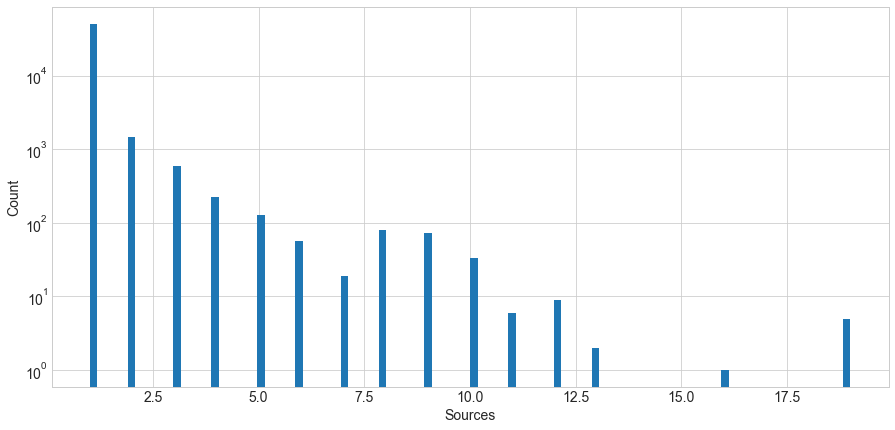

In [4]:
seaborn.set_style("whitegrid")
plot.rcParams["figure.figsize"] = (15, 7)

figure, axis = plot.subplots()
events["NumSources"].hist(ax=axis, bins=100)
axis.set_yscale("log")
axis.tick_params(labelsize=14)
axis.set_xlabel("Sources", fontsize=14)
axis.set_ylabel("Count", fontsize=14)

## Connect to ArcGIS Online anonymously

In [5]:
gis = GIS()

## Display a map of europe
***Hint:*** *map.basemaps shows a list of all available basemaps*

In [6]:
def get_europe_map():
    focus_map = gis.map("Europe")
    focus_map.basemap = "dark-gray-vector"
    return focus_map

focus_map = get_europe_map()

In [7]:
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Create a spatial dataframe for mapping the events from the pandas dataframe
We are using the ActionGeo_Long and ActionGeo_Lat for locating the events. The spatial reference is WGS84 having EPSG-Code of 4326.
- Extract only the columns relevant for mapping and having a simple type (e.g. int64, float64)
- We are dropping all records having "not a number" for latitude or longitude
- We are slicing and creating a deep copy from the events dataframe

In [8]:
mapping_events = events[["GLOBALEVENTID", 
                         "ActionGeo_FullName", 
                         "ActionGeo_Long", 
                         "ActionGeo_Lat", 
                         "NumMentions", 
                         "SOURCEURL"]].dropna(subset=["ActionGeo_Lat", "ActionGeo_Long"]) 
geo_events = geo.from_xy(mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
geo_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51802 entries, 0 to 53241
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   GLOBALEVENTID       51802 non-null  int64   
 1   ActionGeo_FullName  51802 non-null  object  
 2   ActionGeo_Long      51802 non-null  float64 
 3   ActionGeo_Lat       51802 non-null  float64 
 4   NumMentions         51802 non-null  int64   
 5   SOURCEURL           51802 non-null  object  
 6   SHAPE               51802 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 3.2+ MB


## Display a subset of GDELT events on the map
- Sort the events by using the number of mentions in all source documents. The number of mentions could be used to determine how important the event is. Multiple references within a single document are counted too.

In [9]:
del focus_map
focus_map = get_europe_map()
top_mapping_events = mapping_events.sort_values(by="NumMentions", ascending=False).head(n=1000)
top_geo_events = geo.from_xy(top_mapping_events, x_column="ActionGeo_Long", y_column="ActionGeo_Lat", sr=4326)
top_geo_events.spatial.plot(map_widget=focus_map)
focus_map

MapView(layout=Layout(height='400px', width='100%'))

## Display the GDELT events using a heatmap
We are creating a new map widget and convert all "mapping events" to a spatial data frame.

In [10]:
del focus_map
heat_focus_map = get_europe_map()
geo_events.spatial.plot(map_widget=heat_focus_map, renderer_type="h")
heat_focus_map

MapView(layout=Layout(height='400px', width='100%'))